In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import torch
from torch import nn, optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Load Model 

In [3]:
#import models
from Tools.MyModels import CustomResnet152 as myModel

In [4]:
#path model
path = 'checkpoint/checkpoint_resnet152.pt'

model = myModel()
model.load_state_dict(torch.load(path))
model.eval()

criterion = nn.NLLLoss()

In [5]:
# cek model load
model

CustomResnet152(
  (resnet152): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


# Predict

In [6]:
# Make Test datasets and dataloader
batch_size = 32
crop_size = 224

test_transform = transforms.Compose([
    transforms.Resize(crop_size + 7),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

test_set = datasets.ImageFolder('data/test_train/', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### test the trained network

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import seaborn as sn


In [8]:
y_pred = []
y_true = []

# iterate over test data
for feature, target in test_loader:
        output = model(feature) # Feed to model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        target = target.data.cpu().numpy()
        y_true.extend(target) # Save Truth

# constant for classes
test_classes = test_set.classes

In [9]:
# Make confusion_matrix 
cm = confusion_matrix(y_true, y_pred)

In [10]:
# path for plot
plot_path = 'Plot/confusion_matrix_resnet.png'

# Method Plot 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_path)

Confusion matrix, without normalization
[[35  0  0  1  0  0  0]
 [ 2 34  0  0  0  0  0]
 [ 0  0 35  0  0  0  0]
 [ 3  0  0 32  0  0  0]
 [ 0  0  0  0 33  0  0]
 [ 0  0  0  0  0 34  0]
 [ 0  0  0  0  5  0 25]]


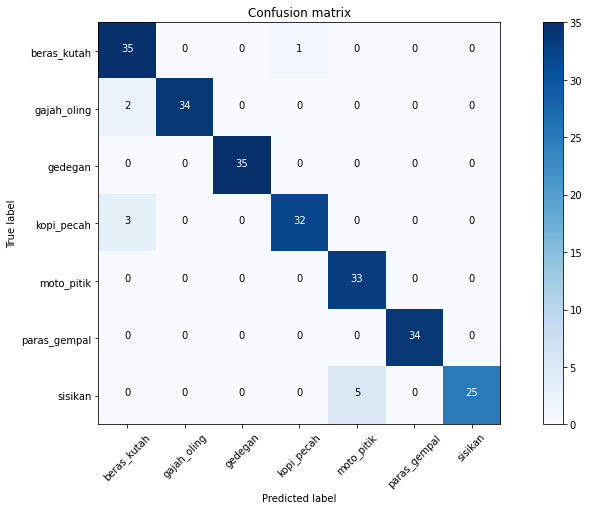

In [11]:
plot_confusion_matrix(cm, test_classes)

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       1.00      0.94      0.97        36
           2       1.00      1.00      1.00        35
           3       0.97      0.91      0.94        35
           4       0.87      1.00      0.93        33
           5       1.00      1.00      1.00        34
           6       1.00      0.83      0.91        30

    accuracy                           0.95       239
   macro avg       0.96      0.95      0.95       239
weighted avg       0.96      0.95      0.95       239



### Visualize Sample Test Sample

In [14]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)
classes = test_set.classes

with torch.no_grad() :
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([5, 2, 4, 1, 0, 2, 4, 3, 2, 5, 3, 6, 3, 1, 0, 4, 5, 2, 3, 3, 4, 4, 6, 4,
        6, 6, 0, 2, 6, 0, 6, 1])

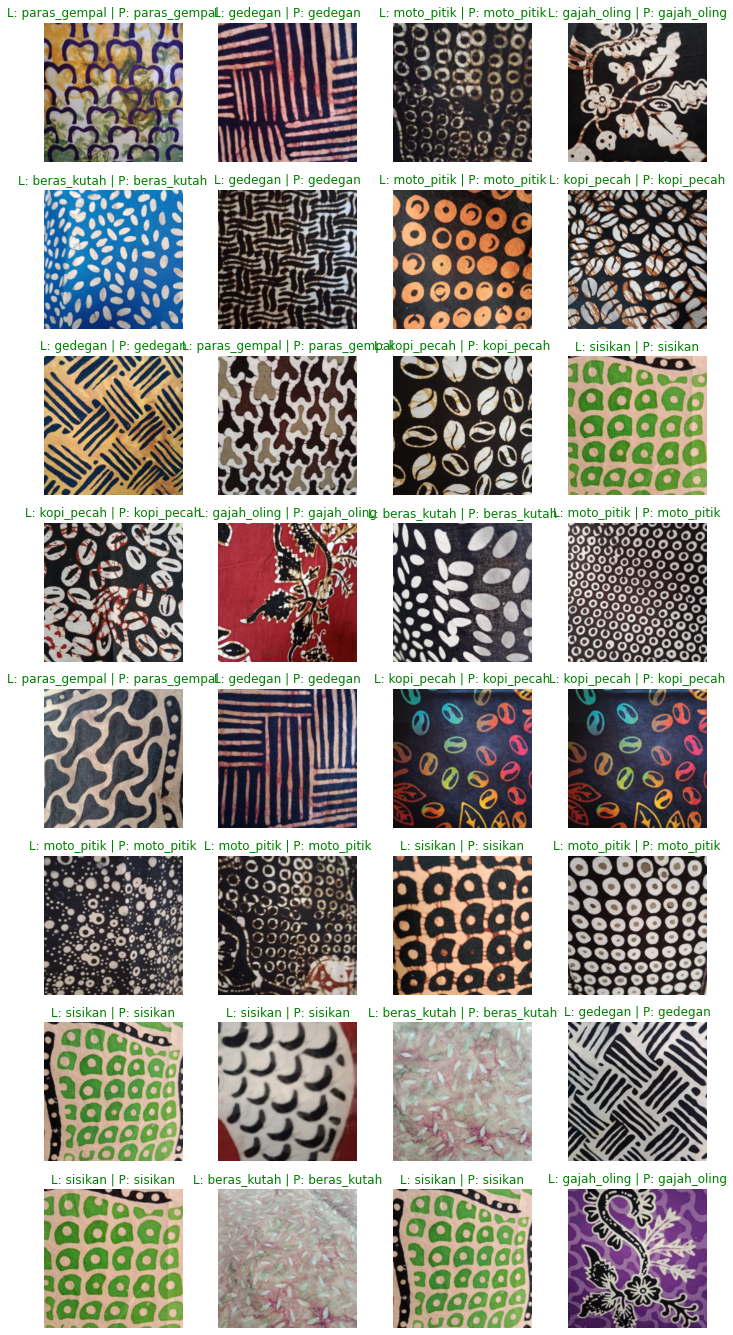

In [15]:
#path for visualize
visualize_plot = 'Plot/Resnet152/visualize_9.png'

fig, axes = plt.subplots(8,4, figsize=(12,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()) :
    ax.imshow(image.permute(1,2,0).cpu())
    font = {'color' : 'r'} if label != pred else {'color' : 'g'}
    label, pred = classes[label.item()], classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font)
    ax.axis('off')
plt.savefig(visualize_plot)

# Save Model

In [ ]:
# save model to hd5 extension
torch.save(model, 'Model/model.h5')

# Prototype 

#### for test the trained model

In [ ]:
# # initialize lists to monitor test loss and accuracy
# test_loss = 0.0
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))

# for data, target in test_loader:
#     if len(target.data) != batch_size:
#         break
#     # forward pass: compute predicted outputs by passing inputs to the model
#     output = model(data)
#     # calculate the loss
#     loss = criterion(output, target)
#     # update test loss 
#     test_loss += loss.item()*data.size(0)
#     # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)
#     # compare predictions to true label
#     correct = np.squeeze(pred.eq(target.data.view_as(pred)))
#     # calculate test accuracy for each object class
#     for i in range(batch_size):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1

# # calculate and print avg test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(10):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             str(i), 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))


#### build confusion matrix

In [ ]:
# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# sn.heatmap(df_cm, annot=True)

#### Visualize

In [ ]:
# random_selection = np.random.randint(0, len(test_predict), 15)

# fig = plt.figure(figsize=(20, 10))
# for i, idx in enumerate(random_selection):
#     image, label = next(iter(test_loader))
#     ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
#     ax.imshow(image)
#     ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
#                 color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

# plt.tight_layout() #want faster comment or delete this
# plt.show()z